In [18]:
import math
import numpy as np
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib
import urllib.request as urlreq
import json
from math import *
from functools import reduce


In [19]:
#Download blocks

downloadNewData = False

if downloadNewData:
    headers = {'User-Agent': 
               'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:76.0) Gecko/20100101 Firefox/76.0'}
    load_size = 10000
    days = 30
    daysPerLoad = load_size*13/(24*3600)
    latest = ""
    blocks = []
    for _ in range(int(days/daysPerLoad)):
        url = 'https://blocks.flashbots.net/v1/blocks?limit={}&before={}'.format(load_size, latest)
        req = urlreq.Request(url=url, headers=headers)
        data = urlreq.urlopen(req).read()
        dic = json.loads(data)
        blocks += dic["blocks"]
        latest = blocks[-1]["block_number"]


    f = open("blocksFrom{}To{}DaysBack.txt".format(blocks[0]["block_number"], days), "w+")
    f.write(json.dumps(blocks))
    f.close()

In [20]:
#Load Blocks from file

#blockNumber = blocks[0]["block_number"] #or substitute from the file
blockNumber = 12695879 #or substitute from the file
daysBack = 30  #or substitute from the file
#Load old ones from here
f = open("blocksFrom{}To{}DaysBack.txt".format(blockNumber, daysBack), "r")
blocks = json.loads(f.read())
f.close()

In [21]:
#Setup
resize = 0.8
plt.rcParams['figure.figsize'] = [resize*25/2.54, resize*20/2.54]
weiToEth = 10**-18
EthToGwei = 10**9
gweiToEth = 10**(-9)
weiToGwei = 10**(-9)
GweiToWei = 10**9
blocks = [block for block in blocks if int(block["miner_reward"]) > 0]
rewards = np.array([int(block["miner_reward"])*weiToEth for block in blocks])
n_blocks = len(blocks)
gas_used = lambda block: int(block["gas_used"])
gas_price = lambda block: int(block["gas_price"])*weiToEth
miner_reward = lambda block: int(block["miner_reward"])*weiToEth

In [22]:
def get_local_maxs(l, within=100):
    def red_fun(a,b):
        if a == []:
            return [b]
        i = a[-1][0]
        r1 = a[-1][1]
        j = b[0]
        r2 = b[1]
        if j - i > within:
            a += [(j, r2)]
        elif r2 > r1:
            a[-1] = (j,r2)
        return a

    return reduce(red_fun, enumerate(l), [])

local_maxs = get_local_maxs(rewards)
indices = [i for i,_ in local_maxs]
maxs = [r for _,r in local_maxs]

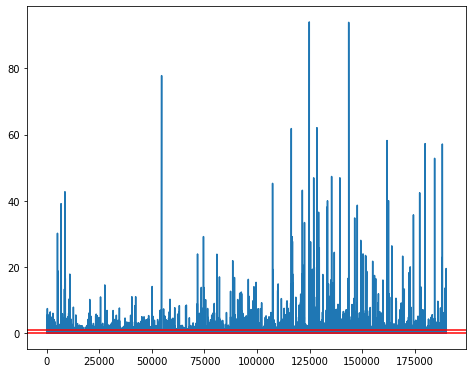

In [23]:
#Visualize flashbots miner rewards

#Note that some txs have 0 gas prices and rewards, probably miner transactions
plt.plot(rewards[0:n_blocks])
mean = np.mean(rewards[0:n_blocks])
std = np.std(rewards[0:n_blocks])
plt.axhline(y = mean, color='r')
plt.axhline(y = mean + std, color='r')
plt.show()

Median fee: 385 gwei
Mean fee: 623 gwei
Mean burn: 0.031 eth
Average burn percentage: 17.4%
Total burn percentage: 17.0%
Average burn percentage without outliers: 17.5%
Total burn percentage without outliers: 20.9%
Percentage of missed slots: 47.8%
Percentage of outliers: 2.5%
Median gas used: 347652
Median priority gas: 54544
Mean gas used: 491869
Mean priority gas: 64494
Mean percentage of original gas used as priority gas: 16.4%


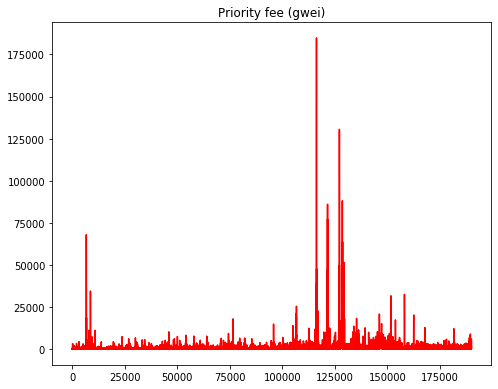

/home/frankdfr/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


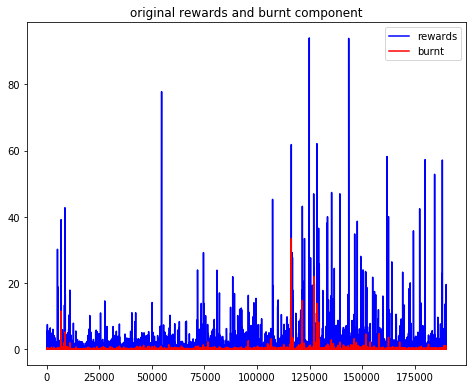

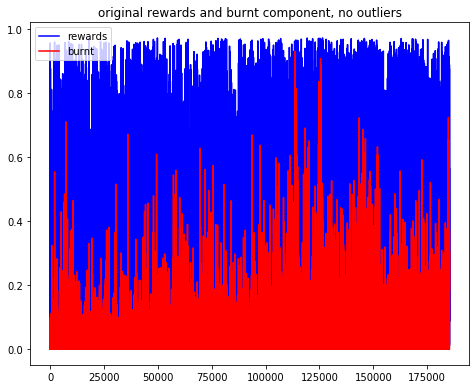

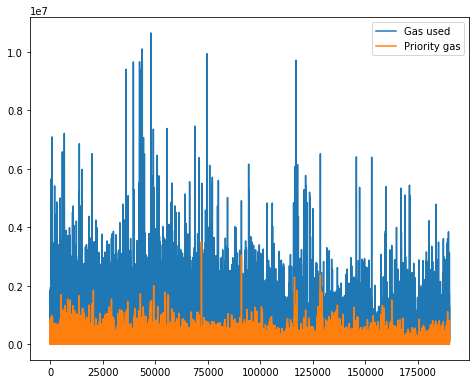

In [24]:
# GAS BASED PRICING, WITH PRIORITY GAS TARGET
priority_fee = 100 #in gwei
new_rewards = np.zeros(n_blocks)
fee = np.zeros(n_blocks)
priority_gas = np.zeros(n_blocks)
burnt = np.zeros(n_blocks)
target = 50000
doubling_days = 3
#halfing_days = 9
increase_factor = np.exp((log(2)/doubling_days)) - 1
#decrease_factor = np.exp((log(0.5)/halfing_days))

for i, block in enumerate(blocks):
    for tx in block["transactions"]:
        if  priority_fee*gweiToEth < int(tx["gas_price"])*weiToEth:
            tx_gas = int(tx["gas_used"])
            tx_burn = tx_gas*priority_fee*gweiToEth
            tx_payment = int(tx["total_miner_reward"])*weiToEth
            new_rewards[i] += tx_payment - tx_burn
            priority_gas[i] += tx_gas
            burnt[i] += tx_burn
    priority_fee *= 1 + (increase_factor)*(priority_gas[i] - target)/target
    fee[i] = priority_fee
    
plt.plot(fee, color = 'r')
plt.title("Priority fee (gwei)")
plt.figure()
plt.plot(rewards, color = 'b')
plt.plot(burnt, color = 'r')
plt.legend(["rewards", "burnt"])
plt.title("original rewards and burnt component")
mean = np.mean(rewards)
var = np.var(rewards)
non_outliers = [i for i, r in enumerate(rewards) if r < mean + var]
plt.figure()
plt.title("original rewards and burnt component, no outliers")
plt.plot(rewards[non_outliers], color = 'b')
plt.plot(burnt[non_outliers], color = 'r')
plt.legend(["rewards", "burnt"])
plt.figure()
plt.plot([gas_used(block) for block in blocks])
plt.plot(priority_gas)
plt.legend(["Gas used", "Priority gas"])

print("Median fee: {:.0f} gwei".format(np.median(fee)))
print("Mean fee: {:.0f} gwei".format(np.mean(fee)))
print("Mean burn: {:.3f} eth".format(np.mean(burnt)))
print("Average burn percentage: {:.1f}%".format(100*np.mean(burnt/rewards)))
print("Total burn percentage: {:.1f}%".format(100*np.sum(burnt)/np.sum(rewards)))
print("Average burn percentage without outliers: {:.1f}%".format(100*np.mean(burnt[non_outliers]/rewards[non_outliers])))
print("Total burn percentage without outliers: {:.1f}%".format(100*np.sum(burnt[non_outliers])/np.sum(rewards[non_outliers])))
print("Percentage of missed slots: {:.1f}%".format(100*np.mean(new_rewards == 0)))
print("Percentage of outliers: {:.1f}%".format(100*(n_blocks - len(non_outliers))/n_blocks))
print("Median gas used: {:.0f}".format(np.median([gas_used(block) for block in blocks])))
print("Median priority gas: {:.0f}".format(np.median(priority_gas)))
print("Mean gas used: {:.0f}".format(np.mean([gas_used(block) for block in blocks])))
print("Mean priority gas: {:.0f}".format(np.mean(priority_gas)))
print("Mean percentage of original gas used as priority gas: {:.1f}%".format(100*np.mean([priority_gas[i]/gas_used(block) for i,block in enumerate(blocks)])))
plt.show()

burnt0 = burnt

Median fee: 0.057 eth
Mean fee: 0.082 eth
Mean burn: 0.038 eth
Average burn percentage: 23.6%
Total burn percentage: 20.8%
Average burn percentage without outliers: 23.9%
Total burn percentage without outliers: 29.0%
Percentage of missed slots: 50.0%
Percentage of outliers: 2.5%
Median gas used: 347652
Median priority gas: 14313
Mean gas used: 491869
Mean priority gas: 305789
Mean percentage of original gas used as priority gas: 50.0%


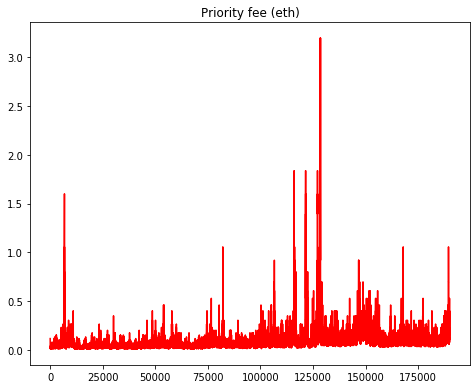

/home/frankdfr/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


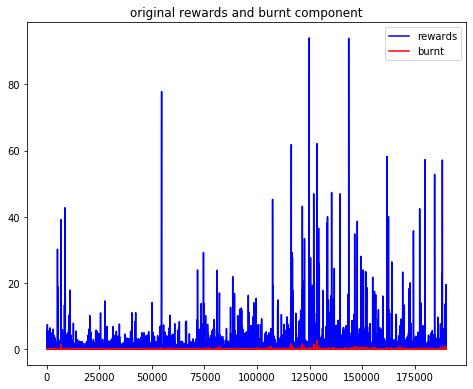

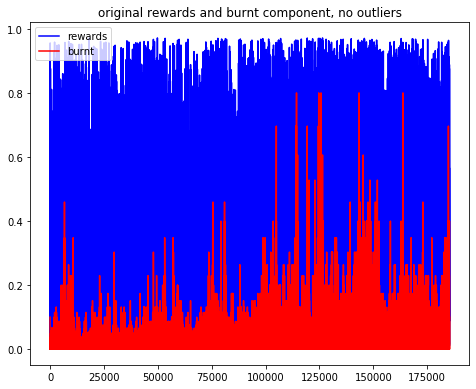

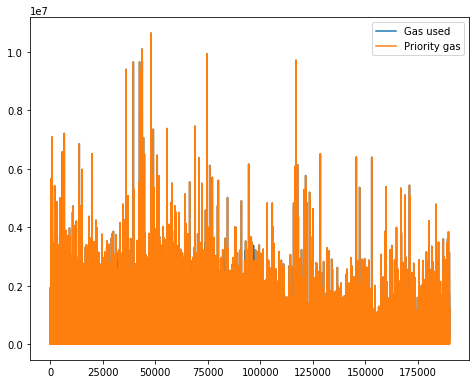

In [25]:
# ONE-OFF FEE PRICING

priority_fee = 0.1 #0.1 ETH
new_rewards = np.zeros(n_blocks)
fee = np.zeros(n_blocks)
priority_gas = np.zeros(n_blocks)
burnt = np.zeros(n_blocks)
doubling_days = 5
halfing_days = 5
increase_factor = np.exp((log(2)/doubling_days))
decrease_factor = np.exp((log(0.5)/halfing_days))

for i, block in enumerate(blocks):
    new_rewards[i] = max(rewards[i] - priority_fee,0)
    if new_rewards[i] > 0:
        burnt[i] = priority_fee
        priority_fee *= increase_factor
        priority_gas[i] = gas_used(block)
    else:
        priority_fee *= decrease_factor
    fee[i] = priority_fee

    
plt.plot(fee, color = 'r')
plt.title("Priority fee (eth)")
plt.figure()
plt.plot(rewards, color = 'b')
plt.plot(burnt, color = 'r')
plt.legend(["rewards", "burnt"])
plt.title("original rewards and burnt component")
mean = np.mean(rewards)
var = np.var(rewards)
non_outliers = [i for i, r in enumerate(rewards) if r < mean + var]
plt.figure()
plt.title("original rewards and burnt component, no outliers")
plt.plot(rewards[non_outliers], color = 'b')
plt.plot(burnt[non_outliers], color = 'r')
plt.legend(["rewards", "burnt"])
plt.figure()
plt.plot([gas_used(block) for block in blocks])
plt.plot(priority_gas)
plt.legend(["Gas used", "Priority gas"])
print("Median fee: {:.3f} eth".format(np.median(fee)))
print("Mean fee: {:.3f} eth".format(np.mean(fee)))
print("Mean burn: {:.3f} eth".format(np.mean(burnt)))
print("Average burn percentage: {:.1f}%".format(100*np.mean(burnt/rewards)))
print("Total burn percentage: {:.1f}%".format(100*np.sum(burnt)/np.sum(rewards)))
print("Average burn percentage without outliers: {:.1f}%".format(100*np.mean(burnt[non_outliers]/rewards[non_outliers])))
print("Total burn percentage without outliers: {:.1f}%".format(100*np.sum(burnt[non_outliers])/np.sum(rewards[non_outliers])))
print("Percentage of missed slots: {:.1f}%".format(100*np.mean(new_rewards == 0)))
print("Percentage of outliers: {:.1f}%".format(100*(n_blocks - len(non_outliers))/n_blocks))
print("Median gas used: {:.0f}".format(np.median([gas_used(block) for block in blocks])))
print("Median priority gas: {:.0f}".format(np.median(priority_gas)))
print("Mean gas used: {:.0f}".format(np.mean([gas_used(block) for block in blocks])))
print("Mean priority gas: {:.0f}".format(np.mean(priority_gas)))
print("Mean percentage of original gas used as priority gas: {:.1f}%".format(100*np.mean([priority_gas[i]/gas_used(block) for i,block in enumerate(blocks)])))
plt.show()

burnt1 = burnt

Median fee: 0.057 eth
Mean fee: 0.076 eth
Mean burn: 0.035 eth
Average burn percentage: 20.5%
Total burn percentage: 19.3%
Average burn percentage without outliers: 20.8%
Total burn percentage without outliers: 26.6%
Percentage of missed slots: 50.0%
Percentage of outliers: 2.5%
Median gas used: 347652
Median priority gas: 14311
Mean gas used: 491869
Mean priority gas: 141804
Mean percentage of original gas used as priority gas: 27.9%


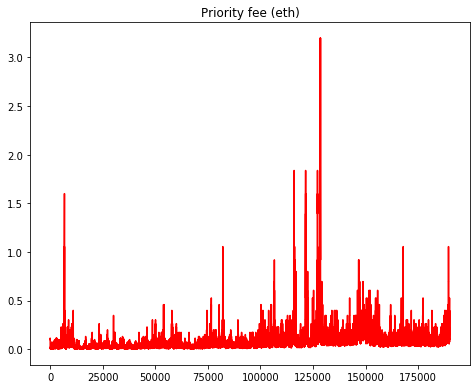

/home/frankdfr/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


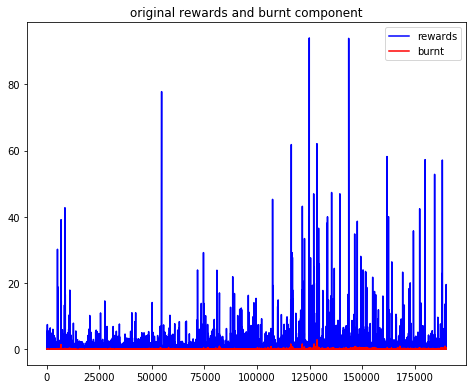

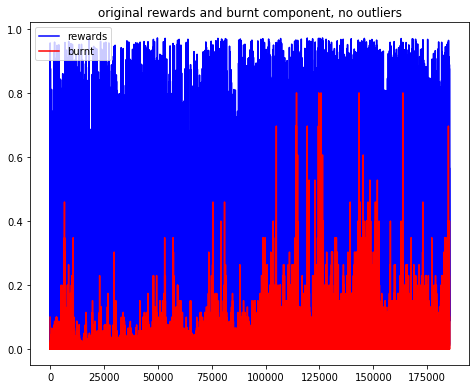

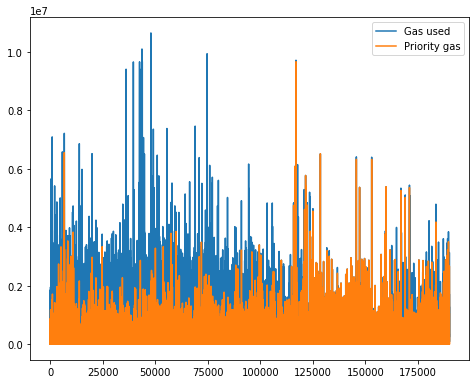

In [26]:
# HYBRID PRICING

one_off_fee = np.zeros(n_blocks)
gas_fee = np.zeros(n_blocks)
one_off_fee[0] = 0.1 # 0.1 ETH
gas_fee[0] = 50 # 100 gwei
new_rewards = np.zeros(n_blocks)
priority_gas = np.zeros(n_blocks)
burnt = np.zeros(n_blocks)
doubling_time = 5
halfing_time = 5
increase_factor = np.exp((log(2)/doubling_time))
decrease_factor = np.exp((log(0.5)/halfing_time))

for i, block in enumerate(blocks):
    for tx in block["transactions"]:
        if  gas_fee[i]*gweiToEth < int(tx["gas_price"])*weiToEth:
            #tx can profitably be included
            tx_gas = int(tx["gas_used"])
            tx_burn = tx_gas*priority_fee*gweiToEth
            tx_payment = int(tx["total_miner_reward"])*weiToEth
            new_rewards[i] += tx_payment - tx_burn
            priority_gas[i] += tx_gas
            burnt[i] += tx_burn
    if new_rewards[i] > one_off_fee[i]:
        new_rewards[i] -= one_off_fee[i]
        burnt[i] += one_off_fee[i]
        if i+1 < n_blocks: one_off_fee[i+1] = one_off_fee[i]*increase_factor
    else:
        new_rewards[i] = 0
        burnt[i] = 0
        priority_gas[i] = 0
        if i+1 < n_blocks: one_off_fee[i+1] = one_off_fee[i]*decrease_factor
    #gas_fee[i+1] = gas_fee[i]*(1 + (gas_increase_factor)*(gas_fee[i] - target)/target)
    if i+1 < n_blocks: gas_fee[i+1] = gas_fee[0]
    
plt.plot(one_off_fee, color = 'r')
plt.title("Priority fee (eth)")
plt.figure()
plt.plot(rewards, color = 'b')
plt.plot(burnt, color = 'r')
plt.legend(["rewards", "burnt"])
plt.title("original rewards and burnt component")
mean = np.mean(rewards)
var = np.var(rewards)
non_outliers = [i for i, r in enumerate(rewards) if r < mean + var]
plt.figure()
plt.title("original rewards and burnt component, no outliers")
plt.plot(rewards[non_outliers], color = 'b')
plt.plot(burnt[non_outliers], color = 'r')
plt.legend(["rewards", "burnt"])
plt.figure()
plt.plot([gas_used(block) for block in blocks])
plt.plot(priority_gas)
plt.legend(["Gas used", "Priority gas"])
print("Median fee: {:.3f} eth".format(np.median(one_off_fee)))
print("Mean fee: {:.3f} eth".format(np.mean(one_off_fee)))
print("Mean burn: {:.3f} eth".format(np.mean(burnt)))
print("Average burn percentage: {:.1f}%".format(100*np.mean(burnt/rewards)))
print("Total burn percentage: {:.1f}%".format(100*np.sum(burnt)/np.sum(rewards)))
print("Average burn percentage without outliers: {:.1f}%".format(100*np.mean(burnt[non_outliers]/rewards[non_outliers])))
print("Total burn percentage without outliers: {:.1f}%".format(100*np.sum(burnt[non_outliers])/np.sum(rewards[non_outliers])))
print("Percentage of missed slots: {:.1f}%".format(100*np.mean(new_rewards == 0)))
print("Percentage of outliers: {:.1f}%".format(100*(n_blocks - len(non_outliers))/n_blocks))
print("Median gas used: {:.0f}".format(np.median([gas_used(block) for block in blocks])))
print("Median priority gas: {:.0f}".format(np.median(priority_gas)))
print("Mean gas used: {:.0f}".format(np.mean([gas_used(block) for block in blocks])))
print("Mean priority gas: {:.0f}".format(np.mean(priority_gas)))
print("Mean percentage of original gas used as priority gas: {:.1f}%".format(100*np.mean([priority_gas[i]/gas_used(block) for i,block in enumerate(blocks)])))
plt.show()

burnt2 = burnt

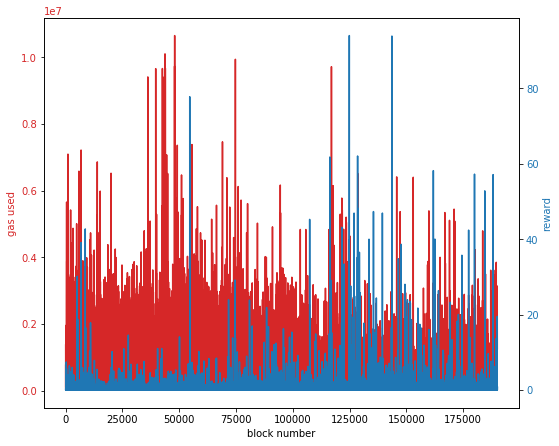

In [27]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('block number')
ax1.set_ylabel('gas used', color=color)
ax1.plot([gas_used(block) for block in blocks], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('reward', color=color) 
ax2.plot(rewards, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()

In [28]:
np.corrcoef([np.array([gas_used(block) for block in blocks]), rewards])[0][1]

0.09152684166662474

/home/frankdfr/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


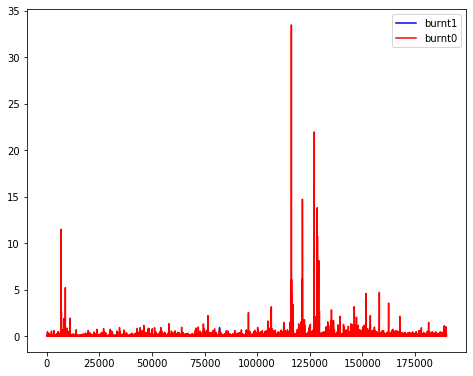

/home/frankdfr/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


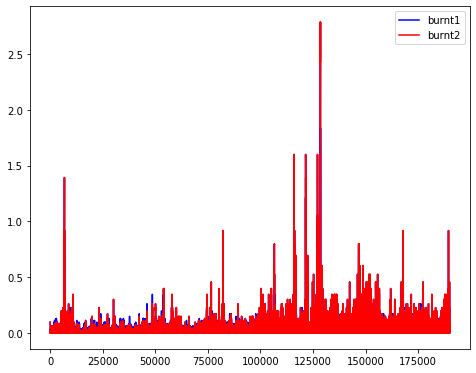

/home/frankdfr/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


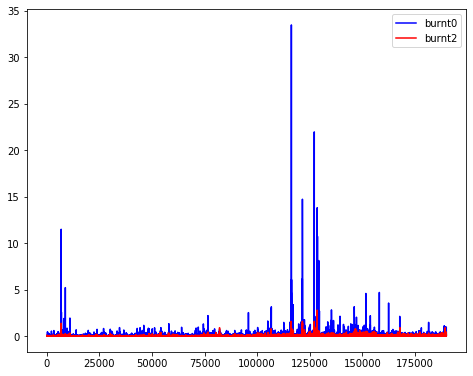

In [29]:
plt.figure()
plt.plot(burnt1, color = 'b')
plt.plot(burnt0, color = 'r')
plt.legend(["burnt1", "burnt0"])
plt.show()

plt.figure()
plt.plot(burnt1, color = 'b')
plt.plot(burnt2, color = 'r')
plt.legend(["burnt1", "burnt2"])
plt.show()

plt.figure()
plt.plot(burnt0, color = 'b')
plt.plot(burnt2, color = 'r')
plt.legend(["burnt0", "burnt2"])
plt.show()

